<a href="https://colab.research.google.com/github/Anas-mhameed/CodeCheckerApp/blob/'main'/CV_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Super resolution with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/super_resolution/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/examples/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Overview

The task of recovering a high resolution (HR) image from its low resolution counterpart is commonly referred to as Single Image Super Resolution (SISR). 

The model used here is ESRGAN
([ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks](https://arxiv.org/abs/1809.00219)). And we are going to use TensorFlow Lite to run inference on the pretrained model.

The TFLite model is converted from this
[implementation](https://tfhub.dev/captain-pool/esrgan-tf2/1) hosted on TF Hub. Note that the model we converted upsamples a 50x50 low resolution image to a 200x200 high resolution image (scale factor=4). If you want a different input size or scale factor, you need to re-convert or re-train the original model.

## Setup

Let's install required libraries first.

In [ ]:
!pip install matplotlib tensorflow tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import dependencies.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.2


Download and convert the ESRGAN model

In [ ]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

@tf.function(input_signature=[tf.TensorSpec(shape=[1, 50, 50, 3], dtype=tf.float32)])
def f(input):
  return concrete_func(input);

converter = tf.lite.TFLiteConverter.from_concrete_functions([f.get_concrete_function()], model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

Download a test image (insect head).

In [ ]:
test_img_path = tf.keras.utils.get_file('lr.jpg', 'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')

6432/6432 [==============================] - 0s 0us/step


## Generate a super resolution image using TensorFlow Lite

In [ ]:
lr = tf.io.read_file(test_img_path)
lr = tf.image.decode_jpeg(lr)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

## Visualize the result

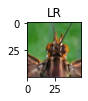

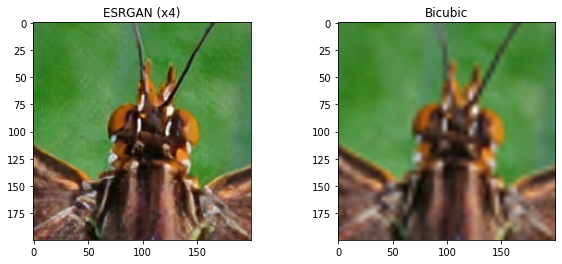

In [ ]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

## Performance Benchmarks

Performance benchmark numbers are generated with the tool
[described here](https://www.tensorflow.org/lite/performance/benchmarks).

<table>
  <thead>
    <tr>
      <th>Model Name</th>
      <th>Model Size </th>
      <th>Device </th>
      <th>CPU</th>
      <th>GPU</th>
    </tr>
  </thead>
  <tr>
    <td rowspan = 3>
      super resolution (ESRGAN)
    </td>
    <td rowspan = 3>
      4.8 Mb
    </td>
    <td>Pixel 3</td>
    <td>586.8ms*</td>
      <td>128.6ms</td>
  </tr>
  <tr>
     <td>Pixel 4</td>
    <td>385.1ms*</td>
      <td>130.3ms</td>
  </tr>

</table>

**4 threads used*